In [105]:

import os 
join = os.path.join

In [106]:
params_composite ={
    "r"         :  0.297,
    "factor_radius": 2,
    "h"         :  0.35,
    "z0"        :  3.073/2,
    "density"   : 8,
    "interface_factor"  :  1.2,
    "with_interface"    : False,
    "mirror"            : True,
    "check_jacobian"    : False,
}

params_ccx = {
    "epsilon" : 0.1,
    "x_fixed" : True
}
params = {
    "mesh" : params_composite,
    "ccx"  : params_ccx,
}

In [107]:
radius = params_composite["r"]
Acarbon = 12*3.14*radius**2

z0 = params_composite["z0"]
h  = params_composite["h"]
Total_Area = 10*(2*h + z0)

In [128]:
z0 + 2*h 

2.2365

In [109]:

from djccx.read_dat import read_dat

def compute_vol_frac(dat_path):
    dat = read_dat(dat_path)
    vols = [ idat["df"]["volume"].sum() for idat in dat]
    vT = vols[1]
    v_yarns = vols[0]/vT
    v_alma  = vols[2]/vT
    v_matrix = 1 - v_yarns - v_alma
    return {
        "yarns"  : v_yarns,
        "matrix" : v_matrix,
        "alma"   : v_alma,
    }

In [110]:
import numpy as np

In [111]:
np.linspace(0.2 ,0.3,5)

array([0.2  , 0.225, 0.25 , 0.275, 0.3  ])

In [112]:
r_span = np.linspace(0.15 ,0.25,5)
r_span

array([0.15 , 0.175, 0.2  , 0.225, 0.25 ])

In [113]:
from djccx.frd.readfrd import readfrd

In [114]:
import glob,os
join = os.path.join

In [115]:
frd_files = glob.glob(join("output","r_*","ccx","*","*.frd"),recursive=True)
frd_files

['output\\r_00\\ccx\\Adouble\\main.frd']

In [116]:
dat_files = glob.glob(join("output","r_*","ccx","*","*.dat"),recursive=True)

In [117]:
ancho = params_composite["z0"] + 0.5*params_composite["h"]
largo = 10 
A = ancho*largo

def compute_Fapl(iffiles):
    ifrd = readfrd(iffiles)
    df = ifrd["data"]
    Fapl = np.sum(df["F2"]*(df["y"] > df["y"].mean()))

    return Fapl

Fapl = [compute_Fapl(f) for f in frd_files]
Sapl = [f/A for f in Fapl]
E_eff = [s / params["ccx"]["epsilon"] for s in Sapl]

In [118]:
vfracs = [compute_vol_frac(f) for f in dat_files]

In [119]:
vfracs

[{'yarns': np.float64(0.1486735968636379),
  'matrix': np.float64(0.16431543716111785),
  'alma': np.float64(0.6870109659752442)}]

In [120]:
from validation.experimental import carbonfiber,resina,nucleo

carbon = carbonfiber()
Ecarbon_MPa = carbon["carbon"].iloc[0]["Young Modulus (GPa)"]*1e3
resina = resina()
nucleo = nucleo()
E_a = nucleo["young modulus [MPa]"]

In [121]:
def analytical(r):
    v_y  = r["yarns"]
    v_m  = r["matrix"]
    v_a  = r["alma"]

    E_y = Ecarbon_MPa/30
    E_m = resina["young modulus [MPa]"]
    E_a = nucleo["young modulus [MPa]"]


    return  E_y*v_y + E_m*v_m + E_a*v_a

E_eff_analytical = [analytical(v) for v in vfracs]
v_carbon = [v["yarns"] for v in vfracs]

In [122]:
print("Carbon",Ecarbon_MPa)
print("Resina",resina["young modulus [MPa]"])
print("Nucleo",nucleo["young modulus [MPa]"])

Carbon 230000.0
Resina 2549.7289999999994
Nucleo 800


In [123]:
vfracs

[{'yarns': np.float64(0.1486735968636379),
  'matrix': np.float64(0.16431543716111785),
  'alma': np.float64(0.6870109659752442)}]

In [124]:
from matplotlib import pyplot as plt

In [125]:
v_carbon = np.array(v_carbon)
E_eff = np.array(E_eff)
E_eff_analytical = np.array(E_eff_analytical)

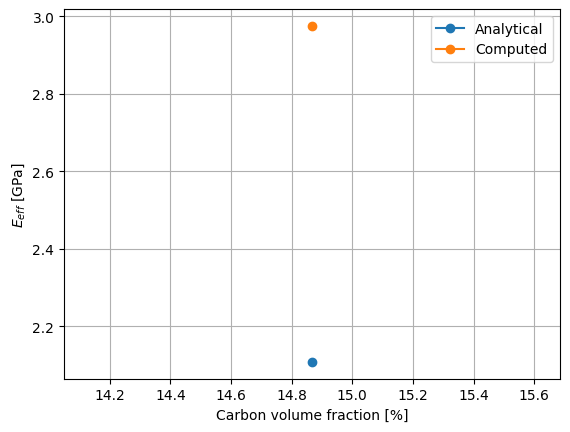

In [126]:
from matplotlib import pyplot as plt
plt.plot(100*v_carbon,E_eff_analytical/1e3,"o-",label="Analytical")
plt.plot(100*v_carbon,E_eff/1e3,"o-",label="Computed")
plt.ylabel(r"$E_{eff}$ [GPa]")
plt.xlabel("Carbon volume fraction [%]")
# grid
plt.grid()
plt.legend()

In [127]:
import pandas as pd
df_save = pd.DataFrame({"vfrac":v_carbon,"E":E_eff})
df_save.to_csv("E_eff_analytical.csv",index=False)